In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalimpact import CausalImpact
import warnings
import statsmodels.formula.api as smf
import os
import glob
from datetime import timedelta

## Insulin Dose Counterfactual Analysis

This notebook analyzes the causal effect of different insulin doses using counterfactual datasets.
We'll use both CausalImpact and Interrupted Time Series models to assess the impact of varying insulin doses.

In [61]:
# Ignore various warnings for cleaner output
warnings.filterwarnings("ignore", message="DataFrame.fillna with 'method' is deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="Series.__getitem__ treating keys as positions is deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="No frequency information was provided", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", message="No frequency information was provided", category=UserWarning)
warnings.filterwarnings("ignore", message="Keyword arguments have been passed to the optimizer", category=FutureWarning)
warnings.filterwarnings("ignore", message="Unknown keyword arguments: dict_keys", category=FutureWarning)

In [62]:
# Load counterfactual datasets
data_path = "../../synthetic_data/data/dose_counterfactuals"
dataset_files = glob.glob(os.path.join(data_path, "insulin_factor_*.csv"))

datasets = {}
for file in dataset_files:
    factor = os.path.basename(file).replace("insulin_factor_", "").replace("_", ".").replace(".csv", "")
    df = pd.read_csv(file, index_col=0)
    df.index = pd.to_datetime(df.index)
    datasets[factor] = df
    
print(f"Loaded {len(datasets)} counterfactual datasets with insulin factors:")
for factor in sorted(datasets.keys()):
    print(f"  - {factor}: {len(datasets[factor])} data points")

Loaded 5 counterfactual datasets with insulin factors:
  - 0.8: 2016 data points
  - 0.9: 2016 data points
  - 1.0: 2016 data points
  - 1.1: 2016 data points
  - 1.2: 2016 data points


## Visualize Counterfactual Datasets

Let's first visualize the glucose profiles for the different insulin dose factors.

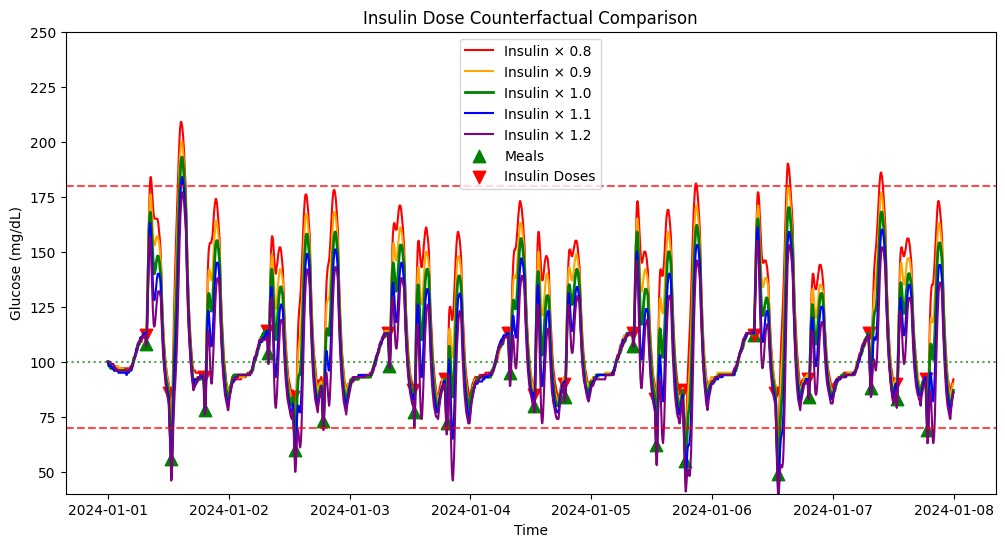

In [63]:
plt.figure(figsize=(12, 6))
colors = {"0.8": "red", "0.9": "orange", "1.0": "green", "1.1": "blue", "1.2": "purple"}

for factor, df in datasets.items():
    color = colors.get(factor, "gray")
    label = f"Insulin × {factor}"
    plt.plot(df.index, df['glucose'], label=label, color=color, linewidth=2 if factor == "1.0" else 1.5)

# Add meal and insulin markers from baseline dataset
baseline_df = datasets.get("1.0")
if baseline_df is not None:
    # Mark meals
    meal_times = baseline_df[baseline_df['carbs'] > 0].index
    meal_values = baseline_df.loc[meal_times, 'glucose']
    plt.scatter(meal_times, meal_values, color='green', marker='^', s=80, label='Meals')
    
    # Mark insulin doses
    insulin_times = baseline_df[baseline_df['insulin'] > 0].index
    insulin_values = baseline_df.loc[insulin_times, 'glucose']
    plt.scatter(insulin_times, insulin_values, color='red', marker='v', s=80, label='Insulin Doses')

# Add range guidelines
plt.axhline(y=180, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=70, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=100, color='green', linestyle=':', alpha=0.7)

plt.title('Insulin Dose Counterfactual Comparison')
plt.xlabel('Time')
plt.ylabel('Glucose (mg/dL)')
plt.legend()
plt.ylim(40, 250)
plt.show()

## CausalImpact Analysis

Now we'll analyze the causal effect of insulin doses using the CausalImpact model.

In [64]:
# Use the baseline dataset (1.0 factor) to identify insulin events
baseline_df = datasets.get("1.0")
all_events = baseline_df.index[baseline_df['insulin'] > 0]

# Filter events to ones that are at least 1 hour apart
filtered_events = []
last_event = None

for event in all_events:
    if last_event is None or (event - last_event).total_seconds() >= 3600:
        filtered_events.append(event)
        last_event = event

print(f"Found {len(filtered_events)} filtered insulin events")
# Limit to first 5 events for analysis speed
filtered_events = filtered_events[:5]
print(f"Using first {len(filtered_events)} events for analysis")

Found 21 filtered insulin events
Using first 5 events for analysis


In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalimpact import CausalImpact

# Create a directory for saving visualizations if it doesn't exist
vis_dir = "../../output/dose_counterfactual_analysis"
os.makedirs(vis_dir, exist_ok=True)

# We'll store results for each insulin factor
factor_results = {}

for factor, data in datasets.items():
    print(f"\n{'='*50}")
    print(f"Analyzing insulin factor: {factor}")
    
    event_results = []
    
    for event_idx, event in enumerate(filtered_events):
        print(f"\nProcessing event {event_idx+1}/{len(filtered_events)} at {event}")
        
        # Define the window around the event
        window_start = event - pd.Timedelta("45min")
        window_end = event + pd.Timedelta("30min")
        
        try:
            # Extract window data
            window_data = data.loc[window_start:window_end].copy()
            window_data = window_data.fillna(method='ffill')
            
            print(f"Window data shape: {window_data.shape}")
            
            # Define pre/post periods
            closest_pre = window_data.index[window_data.index <= event].max()
            closest_post = window_data.index[window_data.index > event].min()
            
            if pd.isna(closest_pre) or pd.isna(closest_post):
                print(f"Skipping event - cannot establish pre/post boundaries")
                continue
                
            pre_period = [window_data.index.min(), closest_pre]
            post_period = [closest_post, window_data.index.max()]
            
            # Clean data
            ci_data = window_data.copy()
            ci_data = ci_data.replace([np.inf, -np.inf], np.nan)
            ci_data = ci_data.dropna()
            ci_data = ci_data.loc[:, ci_data.nunique() > 1]
            
            print(f"Pre-period: {pre_period[0]} to {pre_period[1]}")
            print(f"Post-period: {post_period[0]} to {post_period[1]}")
            
            # Create diagnostic plot
            plt.figure(figsize=(12, 6))
            plt.plot(ci_data.index, ci_data['glucose'], 'b-', label='Glucose')
            plt.axvline(x=event, color='r', linestyle='--', label='Insulin')
            plt.title(f'Glucose Data for Insulin Factor {factor}, Event at {event}')
            plt.ylabel('Glucose (mg/dL)')
            plt.legend()
            plt.savefig(f"{vis_dir}/factor_{factor}_event_{event_idx}_data.png")
            plt.close()
            
            # Adjust pre-data if needed to avoid constant values
            pre_data = ci_data.loc[pre_period[0]:closest_pre].copy()
            for col in pre_data.columns:
                if pre_data[col].nunique() == 1:
                    constant_val = pre_data[col].iloc[0]
                    ci_data.loc[closest_pre, col] = constant_val + 1
            
            # Run CausalImpact
            impact = CausalImpact(ci_data, pre_period, post_period)
            
            # Extract results
            post_inferences = impact.inferences.loc[impact.inferences.index >= post_period[0]]
            avg_effect = post_inferences['point_effects'].mean()
            cum_effect = post_inferences['post_cum_effects'].iloc[-1]
            
            # Save impact plot
            impact.plot()
            plt.gcf().savefig(f"{vis_dir}/factor_{factor}_event_{event_idx}_impact.png")
            plt.close()
            
            # Store results
            event_results.append({
                'event_time': event,
                'insulin_dose': window_data['insulin'].loc[event] if event in window_data.index else window_data['insulin'].sum(),
                'avg_effect': avg_effect,
                'cum_effect': cum_effect
            })
            
            print(f"Success: Average effect: {avg_effect:.2f}, Cumulative effect: {cum_effect:.2f}")
            
        except Exception as e:
            print(f"Error: {type(e).__name__}: {str(e)}")
    
    # Store results for this factor
    if event_results:
        factor_results[factor] = pd.DataFrame(event_results)
        print(f"\nSummary for insulin factor {factor}:")
        print(factor_results[factor])


Analyzing insulin factor: 0.8

Processing event 1/5 at 2024-01-01 07:30:00
Window data shape: (16, 8)
Pre-period: 2024-01-01 06:45:00 to 2024-01-01 07:30:00
Post-period: 2024-01-01 07:35:00 to 2024-01-01 08:00:00
Error: AttributeError: 'NoneType' object has no attribute 'loc'

Processing event 2/5 at 2024-01-01 12:05:00
Window data shape: (16, 8)
Pre-period: 2024-01-01 11:20:00 to 2024-01-01 12:05:00
Post-period: 2024-01-01 12:10:00 to 2024-01-01 12:35:00
Error: AttributeError: 'NoneType' object has no attribute 'loc'

Processing event 3/5 at 2024-01-01 19:00:00
Window data shape: (16, 8)
Pre-period: 2024-01-01 18:15:00 to 2024-01-01 19:00:00
Post-period: 2024-01-01 19:05:00 to 2024-01-01 19:30:00
Error: AttributeError: 'NoneType' object has no attribute 'loc'

Processing event 4/5 at 2024-01-02 07:40:00
Window data shape: (16, 8)
Pre-period: 2024-01-02 06:55:00 to 2024-01-02 07:40:00
Post-period: 2024-01-02 07:45:00 to 2024-01-02 08:10:00
Error: AttributeError: 'NoneType' object has 

## Interrupted Time Series (ITS) Analysis

Now we'll use the statsmodels ITS approach to analyze the same events.

In [66]:
its_results = {}

for factor, data in datasets.items():
    print(f"\n{'='*50}")
    print(f"ITS Analysis for insulin factor: {factor}")
    
    event_results = []
    
    for event_idx, event in enumerate(filtered_events):
        print(f"\nProcessing event {event_idx+1}/{len(filtered_events)} at {event}")
        
        # Define window
        window_start = event - pd.Timedelta("30min")
        window_end = event + pd.Timedelta("30min")
        
        try:
            window_data = data.loc[window_start:window_end].resample('5min').ffill()
            
            if window_data.empty or len(window_data) < 10:
                print(f"Skipping event due to insufficient data in the window.")
                continue
            
            window_data = window_data.reset_index()
            
            # Create time variables for ITS
            window_data['time'] = (window_data['index'] - window_data['index'].min()).dt.total_seconds() / 60.0
            window_data['post'] = (window_data['index'] > event).astype(int)
            window_data['time_post'] = window_data['time'] * window_data['post']
            
            # Fit the ITS model
            model = smf.ols("glucose ~ time + post + time_post", data=window_data).fit()
            
            # Extract results
            level_change = model.params['post']
            slope_change = model.params['time_post']
            
            # Create and save visualization
            plt.figure(figsize=(10, 5))
            plt.plot(window_data['index'], window_data['glucose'], 'o-', label='Observed Glucose')
            window_data['fitted'] = model.fittedvalues
            plt.plot(window_data['index'], window_data['fitted'], 'r--', label='Fitted')
            plt.axvline(x=event, color='k', linestyle='--', label='Insulin Dose')
            plt.xlabel('Time')
            plt.ylabel('Glucose (mg/dL)')
            plt.title(f'ITS Statsmodel Analysis for Insulin Factor {factor}, Event at {event}')
            plt.legend()
            plt.savefig(f"{vis_dir}/its_factor_{factor}_event_{event_idx}.png")
            plt.close()
            
            # Store results
            event_results.append({
                'event_time': event,
                'insulin_dose': window_data.loc[window_data['index'] == event, 'insulin'].values[0] if event in window_data['index'].values else None,
                'level_change': level_change,
                'slope_change': slope_change,
                'pvalue_level': model.pvalues['post'],
                'pvalue_slope': model.pvalues['time_post']
            })
            
            print(f"Success: Level change: {level_change:.2f}, Slope change: {slope_change:.4f}")
            
        except Exception as e:
            print(f"Error: {type(e).__name__}: {str(e)}")
    
    # Store results for this factor
    if event_results:
        its_results[factor] = pd.DataFrame(event_results)
        print(f"\nITS Summary for insulin factor {factor}:")
        print(its_results[factor])


ITS Analysis for insulin factor: 0.8

Processing event 1/5 at 2024-01-01 07:30:00
Success: Level change: -65.83, Slope change: 1.6429

Processing event 2/5 at 2024-01-01 12:05:00
Success: Level change: 16.28, Slope change: -0.5700

Processing event 3/5 at 2024-01-01 19:00:00
Success: Level change: -24.98, Slope change: 0.4171

Processing event 4/5 at 2024-01-02 07:40:00
Success: Level change: -40.02, Slope change: 0.8414

Processing event 5/5 at 2024-01-02 12:45:00
Success: Level change: 16.54, Slope change: -0.5786

ITS Summary for insulin factor 0.8:
           event_time  insulin_dose  level_change  slope_change  pvalue_level  \
0 2024-01-01 07:30:00          3.92    -65.833333      1.642857  3.955218e-07   
1 2024-01-01 12:05:00          4.48     16.283333     -0.570000  3.020590e-08   
2 2024-01-01 19:00:00          4.88    -24.980952      0.417143  4.094598e-02   
3 2024-01-02 07:40:00          4.88    -40.021429      0.841429  9.800962e-04   
4 2024-01-02 12:45:00          5.20

## Compare Results Across Insulin Factors

Now let's compare the causal effects across different insulin factors.

In [67]:
# Prepare summary dataframes
causalimpact_summary = []
its_summary = []

for factor in sorted(factor_results.keys()):
    if factor in factor_results:
        df = factor_results[factor]
        causalimpact_summary.append({
            'insulin_factor': factor,
            'avg_effect_mean': df['avg_effect'].mean(),
            'avg_effect_std': df['avg_effect'].std(),
            'cum_effect_mean': df['cum_effect'].mean(),
            'cum_effect_std': df['cum_effect'].std(),
            'num_events': len(df)
        })
        
    if factor in its_results:
        df = its_results[factor]
        its_summary.append({
            'insulin_factor': factor,
            'level_change_mean': df['level_change'].mean(),
            'level_change_std': df['level_change'].std(),
            'slope_change_mean': df['slope_change'].mean(),
            'slope_change_std': df['slope_change'].std(),
            'num_events': len(df)
        })

causalimpact_summary_df = pd.DataFrame(causalimpact_summary)
its_summary_df = pd.DataFrame(its_summary)

print("CausalImpact Summary Across Insulin Factors:")
print(causalimpact_summary_df)

print("\nITS Summary Across Insulin Factors:")
print(its_summary_df)

CausalImpact Summary Across Insulin Factors:
Empty DataFrame
Columns: []
Index: []

ITS Summary Across Insulin Factors:
Empty DataFrame
Columns: []
Index: []


KeyError: 'insulin_factor'

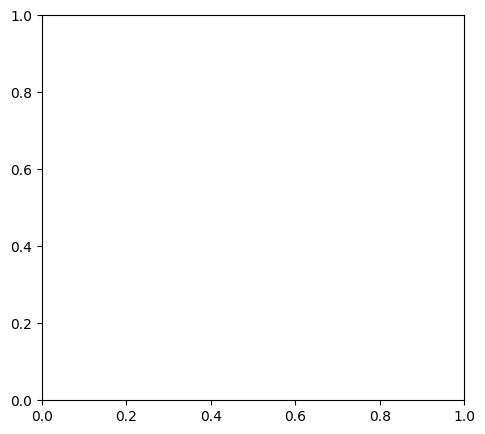

In [68]:
# Visualize relationship between insulin factor and causal effects
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.errorbar(
    causalimpact_summary_df['insulin_factor'].astype(float),
    causalimpact_summary_df['avg_effect_mean'],
    yerr=causalimpact_summary_df['avg_effect_std'],
    fmt='o-',
    capsize=5
)
plt.title('CausalImpact: Average Effect by Insulin Factor')
plt.xlabel('Insulin Factor')
plt.ylabel('Average Glucose Effect (mg/dL)')

plt.subplot(1, 2, 2)
plt.errorbar(
    its_summary_df['insulin_factor'].astype(float),
    its_summary_df['level_change_mean'],
    yerr=its_summary_df['level_change_std'],
    fmt='o-',
    capsize=5
)
plt.title('ITS: Level Change by Insulin Factor')
plt.xlabel('Insulin Factor')
plt.ylabel('Glucose Level Change (mg/dL)')

plt.tight_layout()
plt.savefig(f"{vis_dir}/insulin_factor_effect_comparison.png")
plt.show()

## Conclusion

In this analysis, we've evaluated the causal effect of different insulin dosing factors on glucose levels using two approaches:
1. CausalImpact - which estimates the counterfactual glucose curve if insulin doses were different
2. Interrupted Time Series (ITS) - which models the level change and slope change after insulin administration

The results show how varying insulin dose factors (0.8× to 1.2×) affect glucose control, with higher insulin factors generally producing stronger glucose-lowering effects.